## Yolo Darknet-19 model

We are the yolo2 Darknet-19 forward propagation as we believe it is the optimal tradeoff between predictive performance and computational performance. Further, given that this model is intended to be used for onboard processing, we are further reducing the complexity of the model by having it only learn a single bounding box shape, bounding the number of channels of the output at 29 - thus the output shape will be 19x19x29.

In [1]:
import numpy as np
import tensorflow as tf
from keras import backend as K
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
images = np.load("../data/kwf/images.npy")
encodings = np.load("../data/kwf/encodings.npy")
print(images.shape)
print(encodings.shape)

(2, 608, 608, 3)
(2, 19, 19, 29)


## Model architecture

### Model Forward Prop

In [3]:
# Placeholder values for input X,y data
def get_placeholders(x_h,x_w,x_c,y_h,y_w,y_c):
    """
    x_h: Height for x input 
    x_w: Width for x input
    x_c: Channels for x input
    y_h: Height for y input
    y_w: Width for y input
    y_c: Channels for y input
    """
    X = tf.placeholder(tf.float32, name="X", shape=(None,x_h,x_w,x_c))
    y = tf.placeholder(tf.float32, name="y", shape=(None,y_h,y_w,y_c))
    return X,y

In [4]:
# Defining constant layer for 2d convolution, batch norm, and activation
def conv(the_input,layer,f,ks):
    """
    the_input: the layer which will be used as input in conv layer
    layer: specifies the layer number for naming sections of graph
    f (filters): the number of filters to be used for conv layer
    ks (kernel_size): kernel size for conv2d layer
    Note - conv2d layers all use padding
    """
    layer = str(layer)
    Z = tf.layers.conv2d(the_input,filters=f,kernel_size=[ks,ks],strides=(1,1),padding="same",name="Z"+layer,kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))
    Bn = tf.layers.batch_normalization(Z,name="Bn"+layer)
    A = tf.nn.leaky_relu(Bn,alpha=0.1,name="A"+layer)
    return A

In [5]:
# Building the forward pass based on Darket-19
# Note - forward pass will use leaky_relu
def forward_pass(X):
    input_layer = tf.reshape(X,[-1,608,608,3]) # Input shape of images
    S1 = conv(input_layer,1,32,3)
    P1 = tf.layers.max_pooling2d(S1,pool_size=[2,2],strides=2,padding="valid",name="P1") # 224x224
    S2 = conv(P1,2,64,3)
    P2 = tf.layers.max_pooling2d(S2,pool_size=[2,2],strides=2,padding="valid",name="P2") # 112x112
    S3 = conv(P2,3,128,3)
    S4 = conv(S3,4,64,1)
    S5 = conv(S4,5,128,3)
    P5 = tf.layers.max_pooling2d(S5,pool_size=[2,2],strides=2,padding="valid",name="P5") # 56x56
    S6 = conv(P5,6,256,3)
    S7 = conv(S6,7,128,1)
    S8 = conv(S7,8,256,3)
    P8 = tf.layers.max_pooling2d(S8,pool_size=[2,2],strides=2,padding="valid",name="P8") # 28x28
    S9 = conv(P8,9,512,3)
    S10 = conv(S9,10,256,1)
    S11 = conv(S10,11,512,3)
    S12 = conv(S11,12,256,1)
    S13 = conv(S12,13,512,3)
    P13 = tf.layers.max_pooling2d(S13,pool_size=[2,2],strides=2,padding="valid",name="P13") #14x14
    S14 = conv(P13,14,1024,3)
    S15 = conv(S14,15,512,1)
    S16 = conv(S15,16,1024,3)
    S17 = conv(S16,17,512,1)
    S18 = conv(S17,18,2014,3)
    # Final layer - no batch norm, linear activation
    S19 = tf.layers.conv2d(S18,filters=29,kernel_size=[1,1],strides=(1,1),padding="valid",name="S19",activation=None)
    return S19

In [6]:
# Testing forward prop
tf.reset_default_graph()
ax = np.zeros((1,608,608,3))
X,y = get_placeholders(608,608,3,19,19,29)
Z19 = forward_pass(X)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    aZ = sess.run(Z19,feed_dict={X:ax})
    print("Z shape:", str(aZ.shape))

Z shape: (1, 19, 19, 29)


### Model Cost

In [7]:
# Returns the values with a specific mask applied to it
# Returns all values with the exception of values related to object classes
def get_box_values(box,mask):
    confidence = tf.boolean_mask(box[:,:,:,0:1],mask)
    mid_x = tf.boolean_mask(box[:,:,:,1:2],mask)
    mid_y = tf.boolean_mask(box[:,:,:,2:3],mask)
    width = tf.boolean_mask(box[:,:,:,3:4],mask)
    length = tf.boolean_mask(box[:,:,:,4:5],mask)
    box = {"co":confidence, "mx":mid_x,"my":mid_y,"w":width,"l":length}
    return box

In [8]:
# Returns the class predictions with a specific mask applied to a it
def get_class_values(box,mask):
    values = tf.boolean_mask(box[:,:,:,5:],mask)
    return values

In [9]:
# Heavily penalizes negative predictions for height and weight
def cost_function(Z,y,coord=5,noobj=0.5):
    """
    Z - shape (None,19,19,29)
    y - shape (None,19,19,29)
    """
    c_mask_true = y[:,:,:,0:1] > 0
    c_mask_false = y[:,:,:,0:1] < 1
    
    y_t = get_box_values(y,c_mask_true) # values when there is an object
    z_t = get_box_values(Z,c_mask_true)
    z_f = get_box_values(Z,c_mask_false) # values when there is not an object
    y_f = get_box_values(y,c_mask_false)
    
    # penalizing length,width predictions if they are negative
    z_t["w"] = tf.sqrt(tf.maximum(z_t["w"],0.0))
    z_t["l"] = tf.sqrt(tf.maximum(z_t["l"],0.0))
    y_t["w"] = tf.sqrt(y_t["w"])
    y_t["l"] = tf.sqrt(y_t["l"])
    
    class_mask_true = tf.concat([c_mask_true for i in range(24)],axis=-1) # used for comparing class predictions
    y_classes = get_class_values(y,class_mask_true) # getting the class predictions and actual values
    z_classes = get_class_values(Z,class_mask_true)
    
    # summation of all of the components of the cost function
    part1 = coord * (tf.reduce_sum(tf.square(y_t["mx"]-z_t["mx"]))+tf.reduce_sum(tf.square(y_t["my"]-z_t["my"])))
    part2 = coord * (tf.reduce_sum(tf.square(y_t["w"]-z_t["w"]))+tf.reduce_sum(tf.square(y_t["l"]-z_t["l"])))
    part3 = coord * tf.reduce_sum(tf.square(y_t["co"]-z_t["co"]))
    part4 = noobj * (tf.reduce_sum(tf.square(y_f["co"]-z_f["co"])))
    part5 = tf.reduce_sum(tf.square(y_classes - z_classes))
    
    total_cost = part1 + part2 + part3 + part4 + part5
    return total_cost

In [10]:
# testing cost function
tf.reset_default_graph()
ax = images[0,:,:,:]
ax.shape = (1,608,608,3)
ay = encodings[0,:,:,:]
ay.shape = (1,19,19,29)

X,y = get_placeholders(608,608,3,19,19,29)
Z = forward_pass(X)
cost = cost_function(Z,y)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    acost = sess.run(cost,feed_dict={X:ax,y:ay})
    print(acost)

86.50913


### Model training

In [11]:
# Building and training YOLO model using stochastic gradient descent
def model(X_train,y_train,lr=0.001,num_epochs=50,retrain=True):
    tf.reset_default_graph() # resetting graph
    seed = 0
    costs=[]
    x_h = X_train[0].shape[0]
    x_w = X_train[0].shape[1]
    x_c = X_train[0].shape[2]
    y_h = y_train[0].shape[0]
    y_w = y_train[0].shape[1]
    y_c = y_train[0].shape[2]
    m = X_train.shape[0]
    
    X,y = get_placeholders(x_h,x_w,x_c,y_h,y_w,y_c)
    Z = forward_pass(X)
    cost = cost_function(Z,y)
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() # to save/load model
    with tf.Session() as sess:
        if retrain: # Loading saved model
            saver = tf.train.import_meta_graph("../data/kwf/model/yolo_model.ckpt.meta")
            saver.restore(sess, "../data/kwf/model/yolo_model.ckpt")
        else:
            sess.run(init) # DON'T RUN INIT IF LOADING MODEL
        
        for epoch in range(num_epochs):
            running_cost = 0
            # shuffling training set order each iteration
            seed += 1
            X_train = shuffle(X_train, random_state=seed) 
            y_train = shuffle(y_train, random_state=seed)
            
            for i in range(m):
                aX = X_train[i]
                aX.shape = (1,608,608,3)
                aY = y_train[i]
                aY.shape = (1,19,19,29)
                _,temp_cost = sess.run([optimizer,cost], feed_dict={X:aX,y:aY})
                running_cost += temp_cost
                
            costs.append(running_cost)
            if epoch % 1 == 0:
                print("Cost at epoch {}: {}".format(epoch+1,running_cost))
                
            loc = saver.save(sess, "../data/kwf/model/yolo_model.ckpt") # save on each iteration
            
        return costs

In [12]:
acosts = model(images,encodings,lr=0.0001,num_epochs=50,retrain=False)

Cost at epoch 1: 164.20943450927734
Cost at epoch 2: 149.11538696289062
Cost at epoch 3: 127.4526252746582
Cost at epoch 4: 114.4884033203125
Cost at epoch 5: 99.84981918334961
Cost at epoch 6: 92.98131561279297
Cost at epoch 7: 87.0133056640625
Cost at epoch 8: 85.81857299804688
Cost at epoch 9: 82.86302185058594
Cost at epoch 10: 82.72016906738281
Cost at epoch 11: 81.21874618530273
Cost at epoch 12: 79.26150131225586
Cost at epoch 13: 79.14120483398438
Cost at epoch 14: 78.9744873046875
Cost at epoch 15: 78.26687240600586
Cost at epoch 16: 78.28759384155273
Cost at epoch 17: 78.0519790649414
Cost at epoch 18: 78.05060958862305
Cost at epoch 19: 77.36442565917969
Cost at epoch 20: 77.31285095214844
Cost at epoch 21: 76.3337173461914
Cost at epoch 22: 76.5740852355957
Cost at epoch 23: 75.50202941894531
Cost at epoch 24: 74.74937438964844
Cost at epoch 25: 74.06693649291992
Cost at epoch 26: 75.49128723144531
Cost at epoch 27: 85.47685623168945
Cost at epoch 28: 77.23991394042969
Cost

In [13]:
acosts = model(images,encodings,lr=0.00001,num_epochs=50,retrain=True)

INFO:tensorflow:Restoring parameters from ../data/kwf/model/yolo_model.ckpt
Cost at epoch 1: 64.14051628112793
Cost at epoch 2: 63.77328300476074
Cost at epoch 3: 63.65685844421387
Cost at epoch 4: 63.48127555847168
Cost at epoch 5: 63.170278549194336
Cost at epoch 6: 63.17909240722656
Cost at epoch 7: 62.913835525512695
Cost at epoch 8: 62.68352127075195
Cost at epoch 9: 62.61834526062012
Cost at epoch 10: 62.37942314147949
Cost at epoch 11: 62.22894477844238
Cost at epoch 12: 61.98476028442383
Cost at epoch 13: 61.874237060546875
Cost at epoch 14: 61.67460632324219
Cost at epoch 15: 61.44891929626465
Cost at epoch 16: 61.24675750732422
Cost at epoch 17: 61.0467643737793
Cost at epoch 18: 60.87453269958496
Cost at epoch 19: 60.654693603515625
Cost at epoch 20: 60.42856407165527
Cost at epoch 21: 60.17563247680664
Cost at epoch 22: 59.95083999633789
Cost at epoch 23: 59.746028900146484
Cost at epoch 24: 59.49673843383789
Cost at epoch 25: 59.28770637512207
Cost at epoch 26: 59.03484344

In [26]:
acosts = model(images,encodings,lr=0.00001,num_epochs=50,retrain=True)

INFO:tensorflow:Restoring parameters from ../data/kwf/model/yolo_model.ckpt
Cost at epoch 1: 52.808074951171875
Cost at epoch 2: 51.966949462890625
Cost at epoch 3: 51.487064361572266
Cost at epoch 4: 51.02587699890137
Cost at epoch 5: 50.677053451538086
Cost at epoch 6: 50.47210884094238
Cost at epoch 7: 50.12116622924805
Cost at epoch 8: 49.76201820373535
Cost at epoch 9: 49.53515625
Cost at epoch 10: 49.24631690979004
Cost at epoch 11: 48.90488243103027
Cost at epoch 12: 48.72770309448242
Cost at epoch 13: 48.451303482055664
Cost at epoch 14: 48.04347801208496
Cost at epoch 15: 47.72288131713867
Cost at epoch 16: 47.45479202270508
Cost at epoch 17: 47.15230751037598
Cost at epoch 18: 46.947792053222656
Cost at epoch 19: 46.480363845825195
Cost at epoch 20: 46.12640380859375
Cost at epoch 21: 45.84458351135254
Cost at epoch 22: 45.52786636352539
Cost at epoch 23: 45.16706466674805
Cost at epoch 24: 44.944515228271484
Cost at epoch 25: 44.65936470031738
Cost at epoch 26: 44.6108989715

In [27]:
acosts = model(images,encodings,lr=0.00001,num_epochs=50,retrain=True)

INFO:tensorflow:Restoring parameters from ../data/kwf/model/yolo_model.ckpt
Cost at epoch 1: 36.648576736450195
Cost at epoch 2: 36.065091133117676
Cost at epoch 3: 36.19936943054199
Cost at epoch 4: 35.57183265686035
Cost at epoch 5: 35.73850727081299
Cost at epoch 6: 35.5330228805542
Cost at epoch 7: 35.06141471862793
Cost at epoch 8: 34.27318286895752
Cost at epoch 9: 34.34430122375488
Cost at epoch 10: 34.4985466003418
Cost at epoch 11: 33.242770195007324
Cost at epoch 12: 33.31678867340088
Cost at epoch 13: 32.69247817993164
Cost at epoch 14: 32.05473518371582
Cost at epoch 15: 31.676522254943848
Cost at epoch 16: 31.674819946289062
Cost at epoch 17: 30.839513778686523
Cost at epoch 18: 30.580183029174805
Cost at epoch 19: 30.79055881500244
Cost at epoch 20: 29.776832580566406
Cost at epoch 21: 29.879765510559082
Cost at epoch 22: 29.188100814819336
Cost at epoch 23: 28.870656967163086
Cost at epoch 24: 28.706438064575195
Cost at epoch 25: 28.391298294067383
Cost at epoch 26: 28.4

In [28]:
acosts = model(images,encodings,lr=0.000005,num_epochs=50,retrain=True)

INFO:tensorflow:Restoring parameters from ../data/kwf/model/yolo_model.ckpt
Cost at epoch 1: 22.059093475341797
Cost at epoch 2: 21.63042163848877
Cost at epoch 3: 21.034655570983887
Cost at epoch 4: 20.888023376464844
Cost at epoch 5: 20.708890914916992
Cost at epoch 6: 20.651517868041992
Cost at epoch 7: 20.481494903564453
Cost at epoch 8: 20.445767402648926
Cost at epoch 9: 20.367380142211914
Cost at epoch 10: 20.068395137786865
Cost at epoch 11: 20.197855472564697
Cost at epoch 12: 19.914294242858887
Cost at epoch 13: 20.03656816482544
Cost at epoch 14: 19.988656044006348
Cost at epoch 15: 19.525298595428467
Cost at epoch 16: 19.817681789398193
Cost at epoch 17: 19.38017988204956
Cost at epoch 18: 19.64138698577881
Cost at epoch 19: 19.684982776641846
Cost at epoch 20: 19.72266387939453
Cost at epoch 21: 18.9419903755188
Cost at epoch 22: 19.094377517700195
Cost at epoch 23: 18.74910020828247
Cost at epoch 24: 18.937695503234863
Cost at epoch 25: 18.982796669006348
Cost at epoch 26

In [29]:
acosts = model(images,encodings,lr=0.000005,num_epochs=50,retrain=True)

INFO:tensorflow:Restoring parameters from ../data/kwf/model/yolo_model.ckpt
Cost at epoch 1: 16.197260856628418
Cost at epoch 2: 15.973209381103516
Cost at epoch 3: 15.879683017730713
Cost at epoch 4: 15.966099739074707
Cost at epoch 5: 15.850338459014893
Cost at epoch 6: 15.622607231140137
Cost at epoch 7: 15.527256488800049
Cost at epoch 8: 15.400296211242676
Cost at epoch 9: 15.340882301330566
Cost at epoch 10: 15.262351512908936
Cost at epoch 11: 15.131820678710938
Cost at epoch 12: 15.063595294952393
Cost at epoch 13: 15.001181602478027
Cost at epoch 14: 14.896142959594727
Cost at epoch 15: 14.803203582763672
Cost at epoch 16: 14.697873592376709
Cost at epoch 17: 14.647832870483398
Cost at epoch 18: 14.602721214294434
Cost at epoch 19: 14.48607349395752
Cost at epoch 20: 14.477921485900879
Cost at epoch 21: 14.509167671203613
Cost at epoch 22: 14.430540561676025
Cost at epoch 23: 14.3765869140625
Cost at epoch 24: 14.142442226409912
Cost at epoch 25: 13.961251735687256
Cost at epo

In [32]:
acosts = model(images,encodings,lr=0.000005,num_epochs=50,retrain=True)

INFO:tensorflow:Restoring parameters from ../data/kwf/model/yolo_model.ckpt
Cost at epoch 1: 12.088380336761475
Cost at epoch 2: 12.043171405792236
Cost at epoch 3: 11.800342082977295
Cost at epoch 4: 11.676506042480469
Cost at epoch 5: 11.606095314025879
Cost at epoch 6: 11.521651268005371
Cost at epoch 7: 11.480017185211182
Cost at epoch 8: 11.397210597991943
Cost at epoch 9: 11.322280406951904
Cost at epoch 10: 11.146013736724854
Cost at epoch 11: 11.145286083221436
Cost at epoch 12: 10.990074157714844
Cost at epoch 13: 10.913067817687988
Cost at epoch 14: 10.92157793045044
Cost at epoch 15: 10.810755252838135
Cost at epoch 16: 10.80528450012207
Cost at epoch 17: 10.621950626373291
Cost at epoch 18: 10.535685539245605
Cost at epoch 19: 10.576648712158203
Cost at epoch 20: 10.384016513824463
Cost at epoch 21: 10.335992813110352
Cost at epoch 22: 10.315844058990479
Cost at epoch 23: 10.2562575340271
Cost at epoch 24: 10.373811721801758
Cost at epoch 25: 10.313686847686768
Cost at epoc

### Model inference

In [305]:
# Finds the class with the highest probability for any given 19x19 cell - and returns associated bounding boxes
# boxes are updated to be (y1,x1,y2,x2)
def filter_boxes(Z,threshold=0.6):
    scores = Z[0,:,:,0:1] # 19x19x1
    boxes = Z[0,:,:,1:5] # 19x19x4
    class_probs = Z[0,:,:,5:] # 19x19x24
    
    box_scores = scores * class_probs # 19x19x24
    box_classes = K.argmax(box_scores, axis = -1) # get the class corresponding to max value for cell, 19x19x1
    box_class_scores = K.max(box_scores, axis = -1) # get the max predicted value for the cell, 19x19x1
    
    mask = box_class_scores >= threshold # getting all values that meet a certain predictive threshold
    scores = tf.boolean_mask(box_class_scores, mask) # shape: (None,1)
    boxes = tf.boolean_mask(boxes, mask) # shape: (None,4)
    classes = tf.boolean_mask(box_classes, mask) # shape: (None,1)
    
    # scaling boxes and changing to (y1,x1,y2,x2) format
    coords = tf.where(tf.equal(mask,True)) # coordinates of boxes that met threshold
    width = tf.multiply(boxes[:,2],608)
    height = tf.multiply(boxes[:,3],608)
    width = tf.cast(width,tf.float32)
    height = tf.cast(height,tf.float32)
    elems = (coords,boxes) # holds the coordinates of where each final bounding box is located
    x1 = tf.map_fn(lambda elem: tf.cast(32*elem[1][0],tf.int64)+tf.cast(32*(elem[0][0]-1),tf.int64),elems,tf.int64)
    y1 = tf.map_fn(lambda elem: tf.cast(32*elem[1][1],tf.int64)+tf.cast(32*(elem[0][1]-1),tf.int64),elems,tf.int64)
    x1 = tf.cast(x1,tf.float32)
    y1 = tf.cast(y1,tf.float32)
    y2 = y1 + height
    x2 = x1 + width
    boxes = tf.stack([y1,x1,y2,x2],axis=-1)
    
    return (scores, classes, boxes)

In [306]:
# Finds a set number of the most probable bounding boxes for a given image
def non_max_suppression(scores,classes,boxes,max_boxes=10,iou_thresh=0.5):
    
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes,iou_thresh)
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    
    return (scores,boxes,classes)

In [307]:
# filters out insignificant cell predictions and also performs non-max-suppression
def yolo_eval(Z):
    (scores,classes,boxes) = filter_boxes(Z) # get most probable classes per cell
    (scores,boxes,classes) = non_max_suppression(scores,classes,boxes)
    return (scores,classes,boxes)

In [308]:
# Testing forward prop
tf.reset_default_graph()
ax = images[0,:,:,:]
ax.shape = (1,608,608,3)

X,y = get_placeholders(608,608,3,19,19,29)
Z = forward_pass(X)
answ = yolo_eval(Z)

saver = tf.train.Saver()
with tf.Session() as sess:
    saver = tf.train.import_meta_graph("../data/kwf/model/yolo_model.ckpt.meta")
    saver.restore(sess, "../data/kwf/model/yolo_model.ckpt")
    aansw = sess.run(answ,feed_dict={X:ax})
    print(aansw[0].shape)
    print(aansw[1].shape)
    print(aansw[2].shape)

INFO:tensorflow:Restoring parameters from ../data/kwf/model/yolo_model.ckpt
(10,)
(10,)
(10, 4)


In [309]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [310]:
scores = aansw[0]
classes = aansw[1]
boxes = aansw[2]

In [311]:
img = ax # getting the image back into valid shape and type
img = img * 254
img.shape = (608,608,3)
img = img.astype(int)

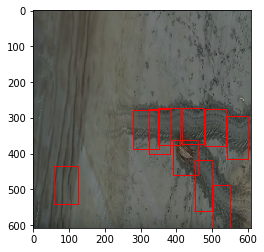

In [312]:
fig,ax = plt.subplots(1)
ax.imshow(img)
for box in boxes: # (y1,x1,y2,x2)
    x1 = box[1]
    y1 = box[0]
    width = box[3] - x1
    height = box[2] - y1
    rect = patches.Rectangle((x1,y1),width,height,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
plt.show()

In [313]:
scores

array([1.1087765 , 1.0741793 , 0.996112  , 0.95954216, 0.9221734 ,
       0.91757053, 0.865166  , 0.808822  , 0.8065409 , 0.6801073 ],
      dtype=float32)

In [314]:
classes

array([15, 15, 15, 15, 15, 15, 15,  1, 15, 15])